# Import libraries

In [1]:
!pip install pyspark
!pip install import-ipynb
!pip install seaborn

In [42]:
# Import necessary libraries
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dataset

In [46]:
# Load the dataset using the custom data loader function
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("Supply Chain Quality Control Data Loader").getOrCreate()

from pyspark.sql import SparkSession

# Specify the file path to the dataset
file_path = "USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset.csv"

# Create a SparkSession
spark = SparkSession.builder.appName("Supply Chain Quality Control Data Loader").getOrCreate()

# Load the CSV file into a DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Basic data information (Schema)

In [ ]:
# Display the schema of the dataset
print("\n=== Data Schema ===")
df.printSchema()

# Checking data shape and size

In [12]:
# Check data shape: number of rows and columns
num_rows = df.count()
num_columns = len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

# Check the size of the data (number of rows * number of columns)
data_size = num_rows * num_columns
print(f"Total data points (size): {data_size}")

Number of rows: 42129
Number of columns: 104
Total data points (size): 4381416


#  Summary statistics for numerical columns

In [15]:
# Convert the Spark DataFrame summary to Pandas for better display
print("\n=== Summary Statistics ===")
df_pandas = df.describe().toPandas().T  # Transpose for better display

# Display the summary statistics table
display(df_pandas)


=== Summary Statistics ===


,0,1,2,3,4
summary,count,mean,stddev,min,max
ROPOLine,42129,None,None,RO10002103PO100002311,• THIS ORDER IS ISSUED BY CHEMONICS INTERNATIO...
Task Order,42129,None,None,DAP,TO4
Condom Adjusted Task Order,42129,466.4,613.203000644974,32.8,TO4
Country,42129,115.5,92.63098833543772,181,Zimbabwe
...,...,...,...,...,...
Pick Up,20977,40.640272679601466,47.4501823836316,-388,672
Deliver,26784,39.667600059737154,44.551930335658625,-404,639
Quality Assurance,3568,31.14097533632287,744.774562085039,-44341,581
Reason Code,27843,48.0,None,48,UD990


# Count missing values per column

In [18]:
# Count missing values for each column
print("\n=== Missing Values ===")
missing_values_df = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

# Convert the missing values to a dictionary and filter columns with missing data
missing_values = missing_values_df.collect()[0].asDict()
missing_values_filtered = {col: count for col, count in missing_values.items() if count > 0}

# Create a DataFrame to display missing values for columns with missing data
missing_values_df = pd.DataFrame(list(missing_values_filtered.items()), columns=['Column', 'Missing Values'])

# Display the missing values table
display(missing_values_df)


=== Missing Values ===


,Column,Missing Values
0,PO DO IO Number,2
1,Item Tracer Category,2
2,Framework Contract,5417
3,D365 Health Element,547
4,D365 Funding Source,550
...,...,...
81,Pick Up,21152
82,Deliver,15345
83,Quality Assurance,38561
84,Reason Code,14286


# Check for duplicates

In [21]:
# 4. Check for duplicates
print("\n=== Checking for Duplicates ===")
duplicate_count = df.groupBy(df.columns).count().filter("count > 1").count()
print(f"Number of duplicate rows: {duplicate_count}")


=== Checking for Duplicates ===
Number of duplicate rows: 0


# Top countries by number of orders

In [24]:
# Display top 10 countries by number of orders
print("\n=== Top Countries by Orders ===")
df.groupBy("Country").count().orderBy(F.desc("count")).show(10)


=== Top Countries by Orders ===
+----------+-----+
|   Country|count|
+----------+-----+
|Mozambique| 5864|
| Congo DRC| 5023|
|   Nigeria| 3927|
|    Zambia| 3620|
|     Haiti| 2848|
|    Uganda| 2248|
|  Ethiopia| 1943|
|  Tanzania| 1916|
|  Zimbabwe| 1308|
|    Rwanda| 1056|
+----------+-----+
only showing top 10 rows



# Distribution of 'Status Name'

In [27]:
# Display distribution of 'Status Name'
print("\n=== Distribution of Status Name ===")
df.groupBy("Status Name").count().orderBy(F.desc("count")).show()


=== Distribution of Status Name ===
+-------------------+-----+
|        Status Name|count|
+-------------------+-----+
| Shipment Delivered|42033|
|Partially Delivered|   81|
|   Shipment Created|   13|
|                  Y|    2|
+-------------------+-----+



# Aggregations: Orders by Country and Product Category

In [30]:
# Display aggregations by Country and Product Category
print("\n=== Aggregations: Orders by Country and Product Category ===")
df.groupBy("Country", "Product Category").agg(
    F.sum("Ordered Quantity").alias("Total Ordered"),
    F.sum("Shipped Quantity").alias("Total Shipped"),
    F.avg("Average Days Late").alias("Avg Days Late")
).orderBy(F.desc("Total Ordered")).show(10)


=== Aggregations: Orders by Country and Product Category ===
+--------------------+--------------------+-------------+-------------+-------------------+
|             Country|    Product Category|Total Ordered|Total Shipped|      Avg Days Late|
+--------------------+--------------------+-------------+-------------+-------------------+
|           Singapore|        Male Condoms|  7.9487222E7|  7.9485243E7| 25.348484848484848|
|             Nigeria|Long Lasting Inse...|  6.5781819E7|  6.5739069E7| 13.520283533587786|
|             Belgium| Oral Contraceptives|  6.4670432E7|  6.4594472E7| 1.5256410256410255|
|             Belgium|Injectable Contra...|    5.57626E7|    5.53238E7|             -4.204|
|             Nigeria|HIV/AIDS Pharmace...|  5.2692119E7|  5.2392919E7|  7.406693883684747|
|            Zimbabwe|        Male Condoms|  5.0791604E7|  5.0791604E7| 12.244186046511627|
|United Arab Emirates|HIV/AIDS Pharmace...|  4.6441893E7|  4.6482745E7|-100.75569061217091|
|            Tanza

# Multivariate analysis: Shipments by Country, Status, and Product Category

In [33]:
# Perform multivariate analysis by Country, Status Name, and Product Category
print("\n=== Multivariate Analysis: Shipments by Country, Status, Product Category ===")
df.groupBy("Country", "Status Name", "Product Category").count().orderBy(F.desc("count")).show(10)


=== Multivariate Analysis: Shipments by Country, Status, Product Category ===
+----------+------------------+--------------------+-----+
|   Country|       Status Name|    Product Category|count|
+----------+------------------+--------------------+-----+
|Mozambique|Shipment Delivered|Laboratory Consum...| 1896|
|    Zambia|Shipment Delivered| Laboratory Reagents| 1703|
|Mozambique|Shipment Delivered| Laboratory Reagents| 1531|
|   Nigeria|Shipment Delivered| Laboratory Reagents| 1438|
|  Ethiopia|Shipment Delivered| Laboratory Reagents| 1130|
| Congo DRC|Shipment Delivered| Essential Medicines| 1077|
| Congo DRC|Shipment Delivered|Malaria Pharmaceu...|  950|
|    Zambia|Shipment Delivered|Laboratory Consum...|  920|
|   Nigeria|Shipment Delivered|Laboratory Consum...|  874|
| Congo DRC|Shipment Delivered|Laboratory Consum...|  704|
+----------+------------------+--------------------+-----+
only showing top 10 rows



# Distribution of Relevant Variables

In [ ]:
# Select relevant numerical variables
relevant_numerical_columns = [
    'Ordered Quantity',
    'Shipped Quantity',
    'Illustrative Price',
    'Average Days Late',
    'Number of Shipments'
]

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pdf = df.select(relevant_numerical_columns).toPandas()

# Check unique value counts for each column
for column in relevant_numerical_columns:
    print(f"{column} unique values: {pdf[column].nunique()}")

# Drop columns with too few unique values or fill NaN
threshold = 2  # Adjust this threshold as needed
filtered_columns = [col for col in relevant_numerical_columns if pdf[col].nunique() > threshold]

# Check the shape of the filtered DataFrame
print("Filtered columns for plotting:", filtered_columns)

# Now, plot histograms for the relevant columns
plt.figure(figsize=(15, 10))

for i, column in enumerate(filtered_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(pdf[column].dropna(), kde=True)  # Drop NaN for plotting
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

Ordered Quantity unique values: 9492
Shipped Quantity unique values: 9525
Illustrative Price unique values: 2925
Average Days Late unique values: 930
Number of Shipments unique values: 26
Filtered columns for plotting: ['Ordered Quantity', 'Shipped Quantity', 'Illustrative Price', 'Average Days Late', 'Number of Shipments']


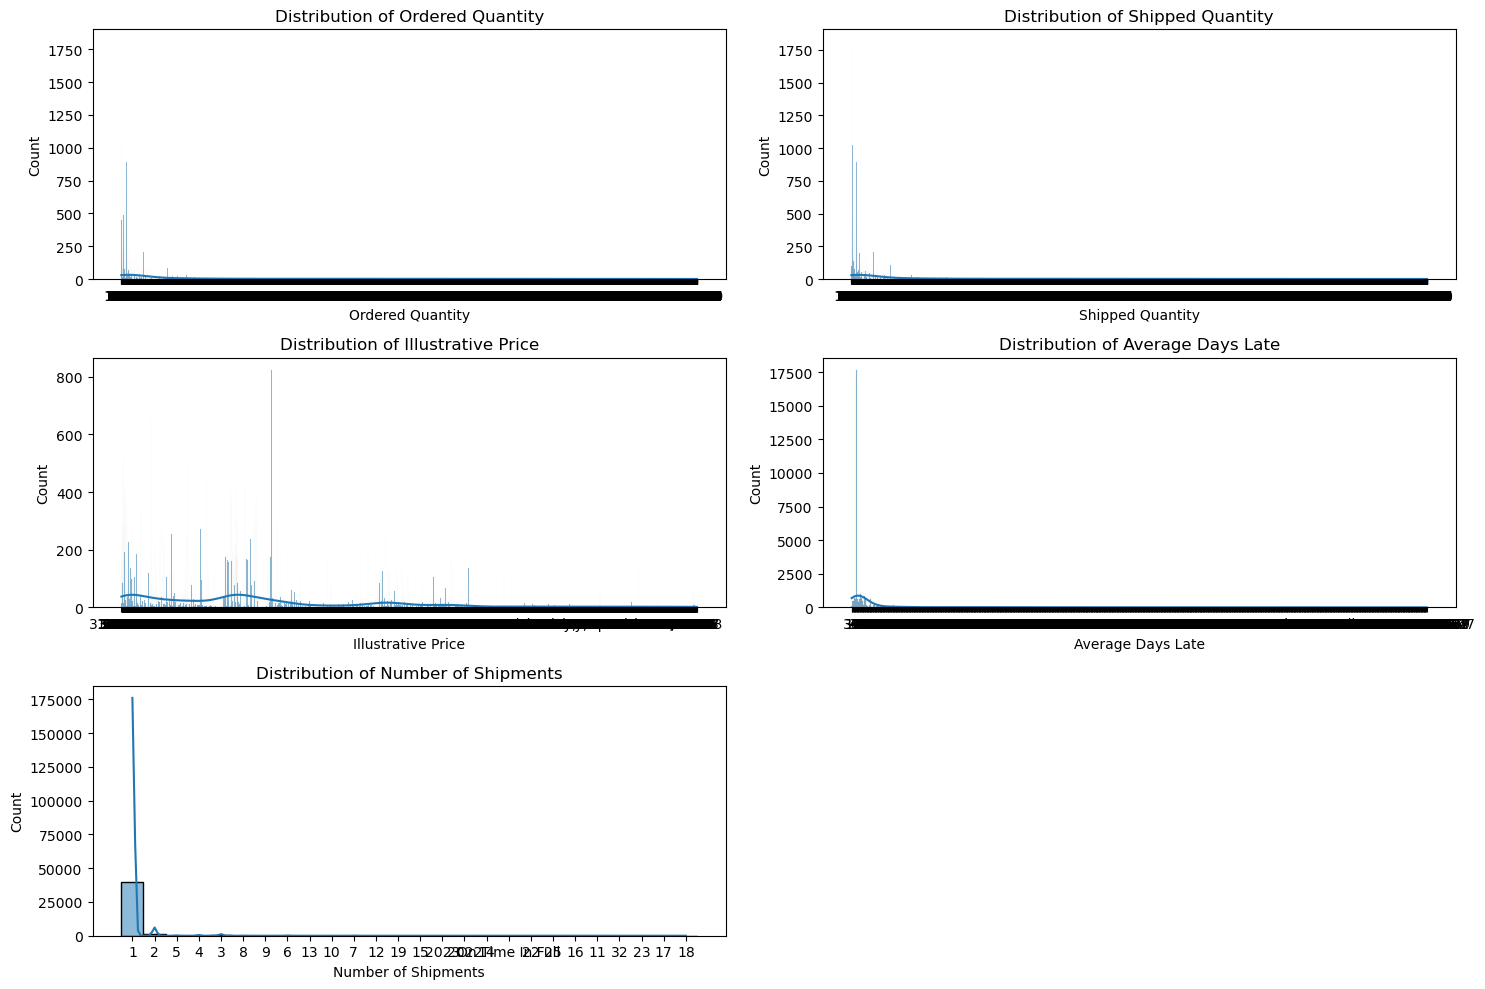

In [60]:
# Convert PySpark DataFrame to Pandas DataFrame for plotting
pdf = df.select(filtered_columns).toPandas()

# Set the figure size for better readability
plt.figure(figsize=(15, 10))

# Create histograms for each filtered column
for i, column in enumerate(filtered_columns, 1):
    plt.subplot(3, 2, i)  # Adjust the subplot grid if needed
    sns.histplot(pdf[column].dropna(), kde=True)  # Drop NaN values for plotting
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Correlation Among Relevant Variables

Ordered Quantity unique values: ['15' '210' '26' ... '63668' '571131' '9925']
Shipped Quantity unique values: ['15' '210' '26' ... '63668' '571131' '9925']
Illustrative Price unique values: ['25.75' '137' '64.4' ... '20.19' '4.84' '2.97']
Average Days Late unique values: ['30' '4' '18' '3' '-7' '-6' '5' '-4' '0' '-8' '-12' '-10' '-5' '-3' '-1'
 '1' '6' '-2' '-11' '13' '-14' '7' '-9' '2' '20' '24' '29' '-15' '15' '9'
 '-13' '23' '-28' '21' '-17' '8' '10' '11' '14' '-16' '-18' '17' '12' '28'
 '26' '-20' '27' '22' '25' '19' '16' '-47' '-37' '-48' '-54' '-71' '-80'
 '-32' '-69' '-76' '-35' '31' '32' '39' '34' '211' '73' '43' '35' '105'
 '41' '46' '109' '62' '58' '114' '52' '69' '33' '120' '106' '111' '125'
 '159' '54' '45' '55' '75' '50' '78' '104' '103' '222' '84' '113' '64'
 '42' '122' '345' '161' '16.5' '27.5' '17.5' '10.5' '15.5' '97.5' '49.5'
 '43.5' '20.5' '165.5' '-2.5' '167' '340' '53' '-204' '-233' '210' '40'
 '373' '66' '96' '172' '166' '-149' '-206' '-30' '-190' '124' '-178' '37

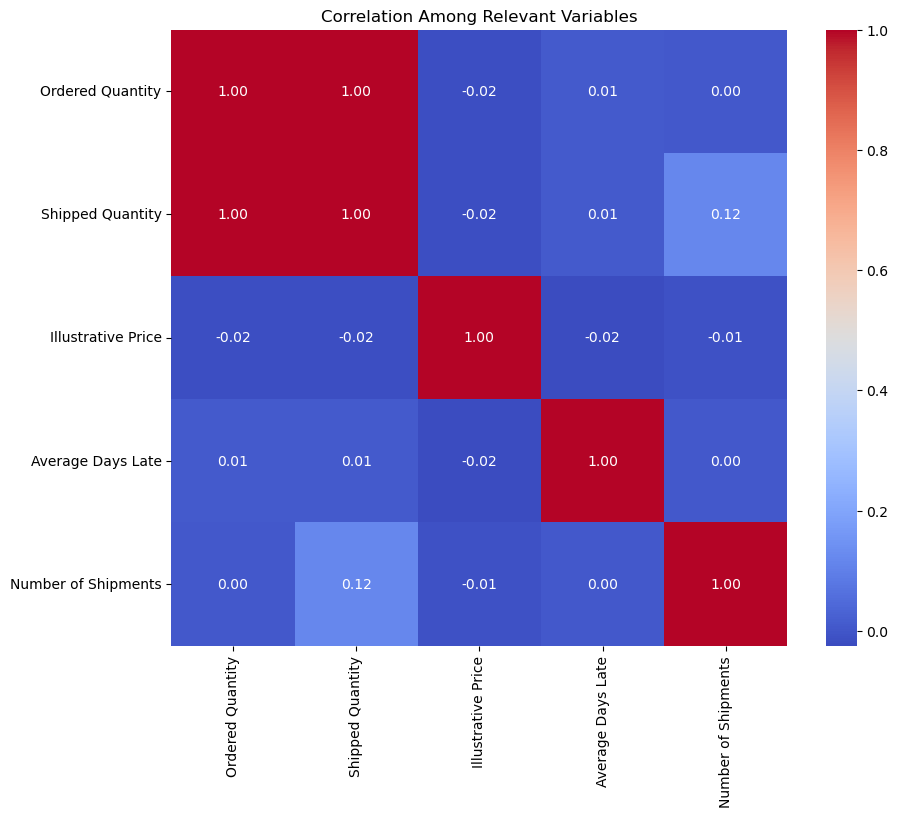

In [66]:
# Convert relevant columns to numerical type (if they are not already)
numerical_df = df.select(relevant_numerical_columns).toPandas()

# Check the data types and unique values for each column to identify non-numeric entries
for column in numerical_df.columns:
    print(f"{column} unique values: {numerical_df[column].unique()}")

# Convert columns to numeric, coercing errors to NaN
numerical_df = numerical_df.apply(pd.to_numeric, errors='coerce')

# Optionally, drop rows with NaN values if you want to clean the dataset
# numerical_df = numerical_df.dropna()

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Among Relevant Variables')
plt.show()

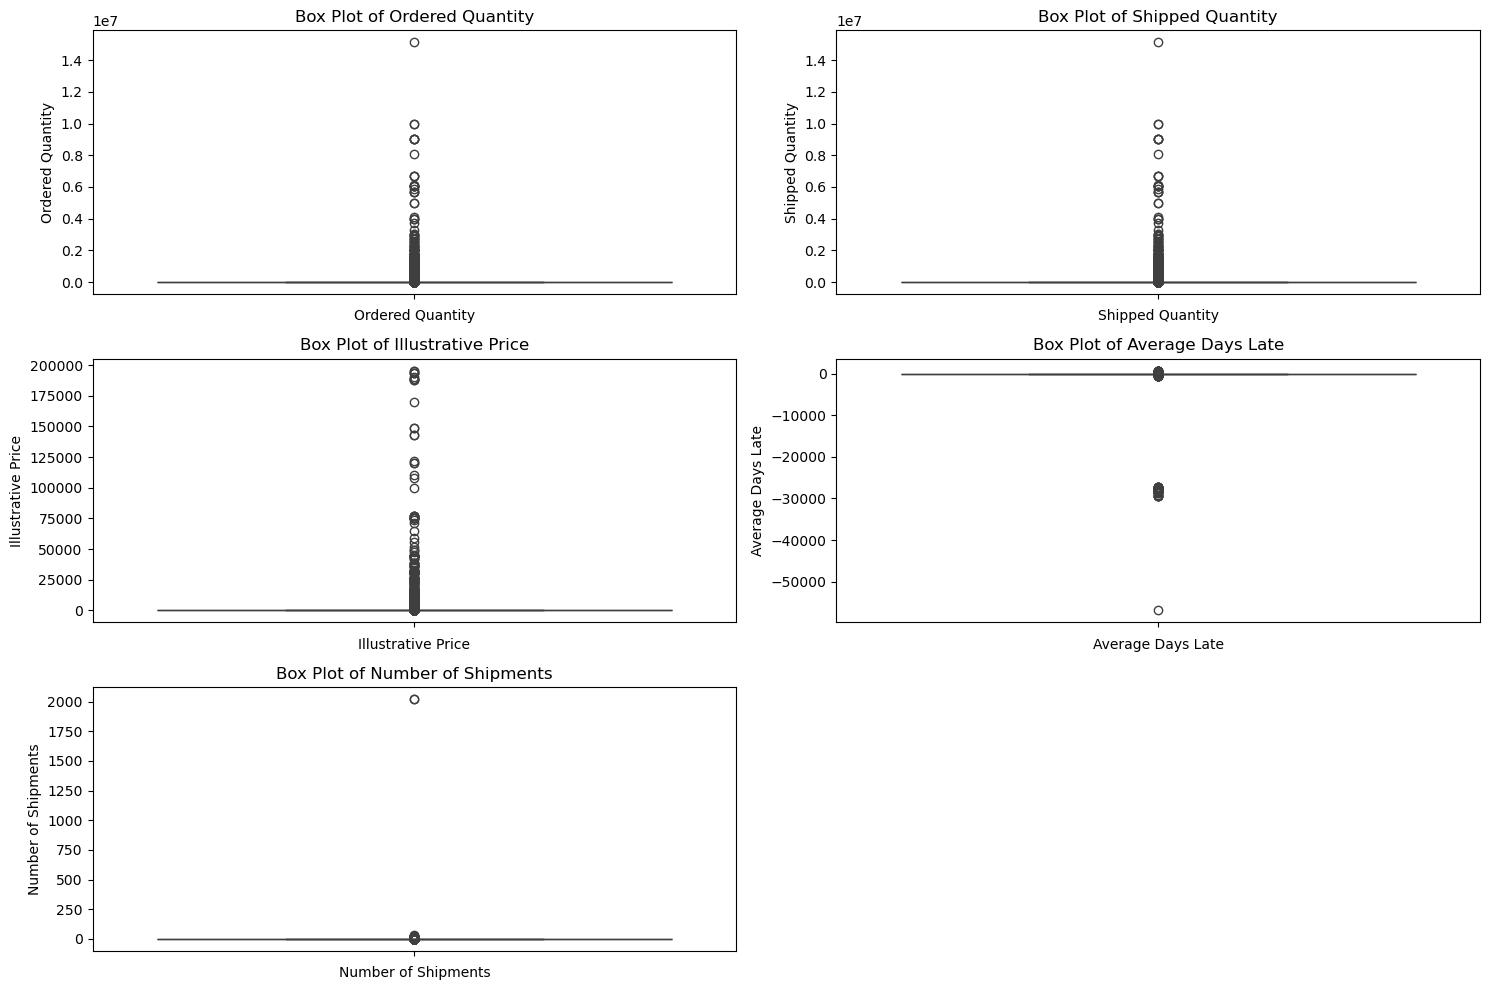

In [68]:
# Outlier detection

import seaborn as sns
import matplotlib.pyplot as plt

# Convert relevant columns to numerical type (if they are not already)
numerical_df = df.select(relevant_numerical_columns).toPandas()

# Convert columns to numeric, coercing errors to NaN
numerical_df = numerical_df.apply(pd.to_numeric, errors='coerce')

# Set the size of the plots
plt.figure(figsize=(15, 10))

# Create box plots for each numerical column
for i, column in enumerate(numerical_df.columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=numerical_df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

# Adjust layout
plt.tight_layout()
plt.show()